## Covid-19 Fake news Detection - EDA

### Importing required library

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
import matplotlib.pyplot as plt
import nltk 
from nltk import tokenize
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
import scipy.stats as stats
import string
from collections import defaultdict, Counter
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models
import gensim
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import itertools
from sklearn.metrics import accuracy_score

### Loading dataset and giving name to columns

In [2]:
df=pd.read_csv('covidnews.txt', sep="\t", header=None)
df.columns = ["label", "text"]

In [3]:
df.head()

,label,text
0,0,live launch of the access to covid tools act...
1,0,live one world togetherathome covid
2,1,dettol kills the coronavirus so it is not new
3,1,one thing for sure drink enough bleach and t...
4,1,isn t that horrible china has a patent on th...


In [4]:
# counting the number of missing values in the dataset
df.isnull().sum()

label    0
text     0
dtype: int64

### Defining a function for Preprocessing the data using NLP 

In [5]:
port_stem = PorterStemmer()
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [6]:
df['text'] = df['text'].apply(stemming)

In [7]:
df['text'][50]

'mcgarri report bill gate predict coronaviru like outbreak'

In [8]:
df['text']

0                live launch access covid tool act acceler
1                       live one world togetherathom covid
2                               dettol kill coronaviru new
3        one thing sure drink enough bleach coronaviru ...
4        horribl china patent viru alreadi laboratori b...
                               ...                        
21995    get latest updat covid respons massachusett st...
21996                 hold brief covid virginia watch live
21997    mani countri put place restrict measur physic ...
21998    expert hand sanitis made alcohol kill coronavi...
21999    salli c pipe warren schakowski bill would push...
Name: text, Length: 22000, dtype: object

label
0    11000
1    11000
Name: text, dtype: int64


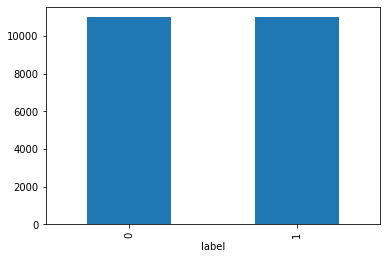

In [9]:
print(df.groupby(['label'])['text'].count())
df.groupby(['label'])['text'].count().plot(kind="bar")
plt.show()

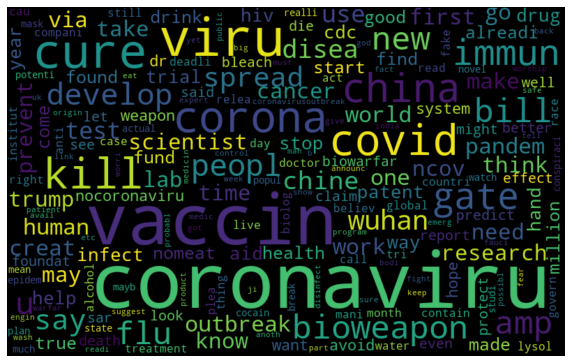

In [10]:
#word cloud plotting_fake_news
fake_data = df[df["label"]==1]
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

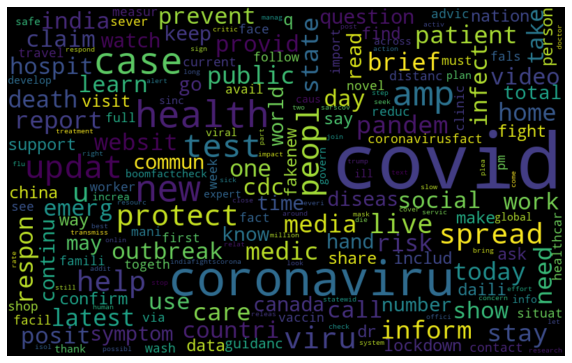

In [11]:
#word cloud plotting_real_news
fake_data = df[df["label"]==0]
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
# Most frequent words counter 
token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

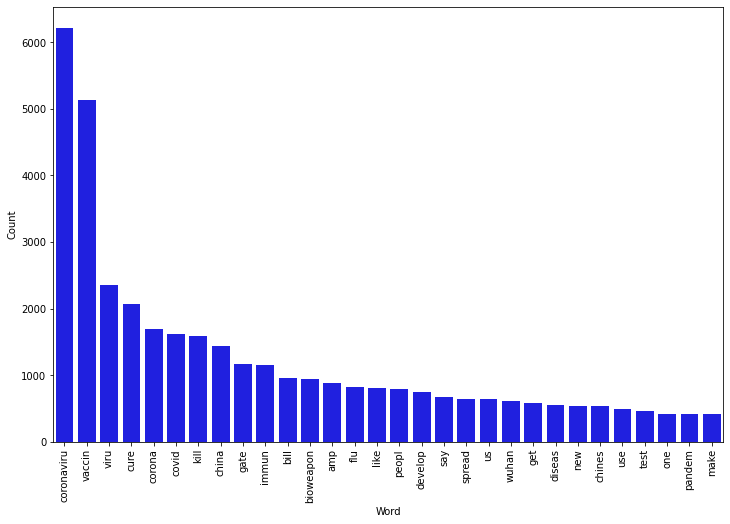

In [16]:
# Most frequent words in fake news
counter(df[df["label"] == 1], "text", 30)

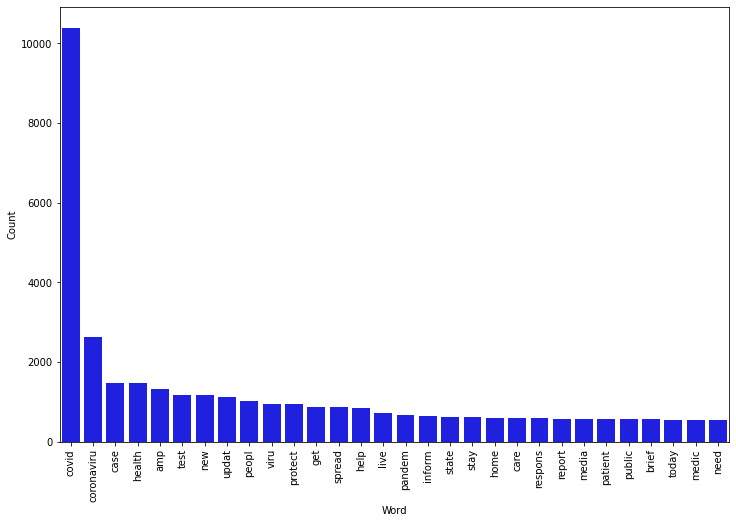

In [14]:
# Most frequent words in real news
counter(df[df["label"] == 0], "text", 30)

In [17]:
reindexed_data = df['text']

In [18]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\monak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\monak\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [20]:
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per news: ', np.mean(word_counts))

Total number of words:  295560
Mean number of words per news:  13.434545454545454


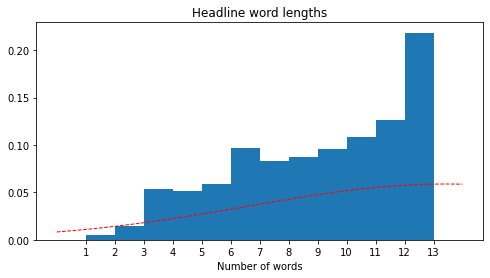

In [21]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

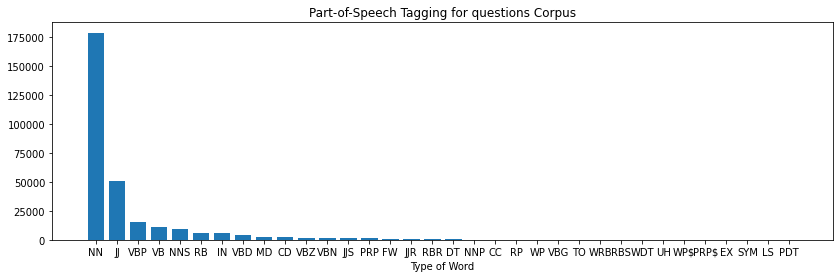

In [22]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(14,4))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for questions Corpus');
ax.set_xlabel('Type of Word');

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

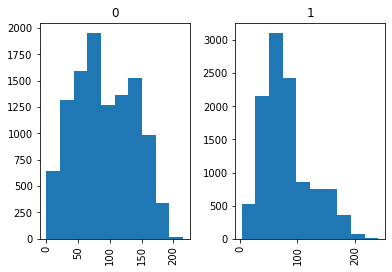

In [25]:
#  the number of characters present in each text by labels
df['text'].str.len().hist(by=df['label'])

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

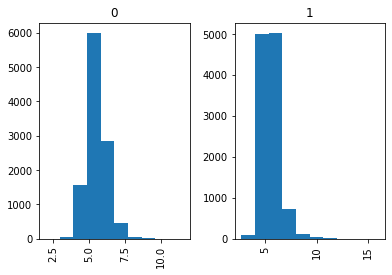

In [27]:
# Word level analysis of text
df['text'].str.split().apply(lambda x:[len(i) for i in x]).map(lambda x: np.mean(x)).hist(by=df['label'])

In [28]:
# Remove stopwords from title and text by label
messages_fake=df[df.label==1].copy()
messages_not_fake=df[df.label==0].copy()

In [50]:
length_fake = messages_fake['text'].str.split().apply(len)
length_fake.mean()

12.65309090909091

In [51]:
length_real = messages_not_fake['text'].str.split().apply(len)
length_real.mean()

14.13

In [60]:
df_raw=pd.read_csv('covidnews.txt', sep="\t", header=None)
df_raw.columns = ["label", "text"]
df_raw.head()

,label,text
0,0,live launch of the access to covid tools act...
1,0,live one world togetherathome covid
2,1,dettol kills the coronavirus so it is not new
3,1,one thing for sure drink enough bleach and t...
4,1,isn t that horrible china has a patent on th...


In [61]:
raw_fake=df_raw[df_raw.label==1].copy()
raw_not_fake=df_raw[df_raw.label==0].copy()

In [62]:
raw_length_fake = raw_fake['text'].str.split().apply(len)
raw_length_fake.mean()

21.373

In [63]:
raw_length_real = raw_not_fake['text'].str.split().apply(len)
raw_length_real.mean()

23.684272727272727

<AxesSubplot:>

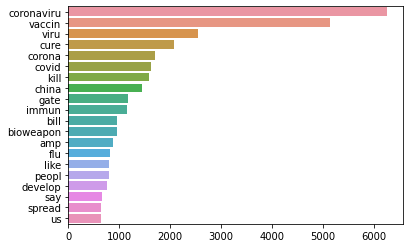

In [36]:
# Corpus analysis corpus_text_fake

messages_fake['text'] = messages_fake['text'].apply(stemming)

stop=set(stopwords.words('english'))
messages_fake['text'] = messages_fake['text'].str.lower()
messages_fake['text'] = messages_fake.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = messages_fake['text'].str.split()
new=new.values.tolist()
corpus_text_fake=[word for i in new for word in i]

counter=Counter(corpus_text_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:20]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

<AxesSubplot:>

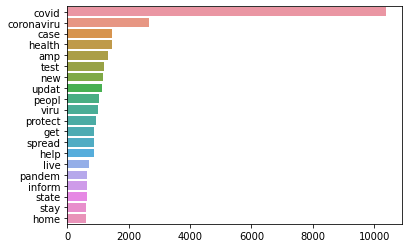

In [35]:
# Corpus analysis corpus_text_not_fake
messages_not_fake['text'] = messages_not_fake['text'].apply(stemming)

stop=set(stopwords.words('english'))
messages_not_fake['text'] = messages_not_fake['text'].str.lower()
messages_not_fake['text'] = messages_not_fake.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = messages_not_fake['text'].str.split()
new=new.values.tolist()
corpus_text_not_fake=[word for i in new for word in i]

counter=Counter(corpus_text_not_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:20]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [52]:
# Ngram analysis function

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<AxesSubplot:>

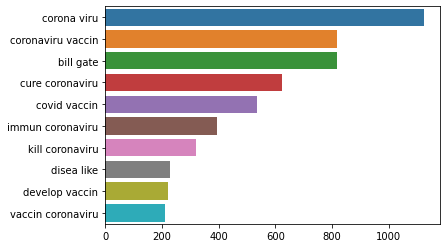

In [53]:
# Ngram analysis corpus_text_fake
messages_fake['text'] = messages_fake['text'].apply(stemming)
messages_fake['text'] = messages_fake['text'].str.lower()
messages_fake['text'] = messages_fake.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
messages_fake['text'] = messages_fake['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(messages_fake['text'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

<AxesSubplot:>

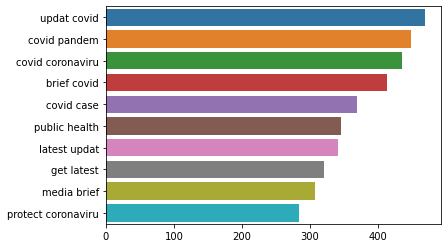

In [54]:
# Ngram analysis corpus_text_not_fake
messages_not_fake['text'] = messages_not_fake['text'].apply(stemming)
messages_not_fake['text'] = messages_not_fake['text'].str.lower()
messages_not_fake['text'] = messages_not_fake.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
messages_not_fake['text'] = messages_not_fake['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(messages_not_fake['text'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

In [55]:
#  Preprocess function for LDA
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
def preprocess_news(df,column):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df[column]:
        words=[w for w in word_tokenize(news) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\monak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\monak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\monak\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [58]:
#LDA for corpus_text_fake
corpus = preprocess_news(messages_fake,'text')
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
pyLDAvis.save_html(vis, 'lda_fake_text.html')
lda_model.show_topics()
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.057169  0.034458       1        1  32.317159
3      0.146977 -0.090913       2        1  29.953561
0     -0.031236  0.149312       3        1  19.291122
1     -0.172910 -0.092857       4        1  18.438158, topic_info=       Term         Freq        Total Category  logprob  loglift
17   vaccin  4687.000000  4687.000000  Default  30.0000  30.0000
2      kill  1465.000000  1465.000000  Default  29.0000  29.0000
24     cure  1861.000000  1861.000000  Default  28.0000  28.0000
78   corona  1522.000000  1522.000000  Default  27.0000  27.0000
18     viru  2331.000000  2331.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
328    stop   116.394281   248.164184   Topic4  -5.3600   0.9336
73    immun   159.048637  1072.883200   Topic4  -5.0478  -0.2181
119   covid   155.229278  1500.550173   Topic4  -5.0721  -0.5779
5     drink    95.936665   218.104901   Topic4  -5.5533   0.8695
358     use    88.330347   454.247325   Topic4  -5.6359   0.0532

[285 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
527       1  0.963066  accid
527       2  0.018521  accid
527       4  0.018521  accid
412       1  0.979370   accu
360       3  0.990806    act
...     ...       ...    ...
51        1  0.754638  wuhan
51        2  0.105506  wuhan
51        3  0.032188  wuhan
51        4  0.107294  wuhan
1994      4  0.973002    wwg

[495 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

In [59]:
#LDA for corpus_text_not_fake
corpus = preprocess_news(messages_not_fake,'text')
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
pyLDAvis.save_html(vis, 'lda_not_fake_text.html')
lda_model.show_topics()
vis

C:\Users\monak\anaconda3\envs\blhl\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.033232 -0.083795       1        1  41.371108
1      0.035706 -0.109095       2        1  24.186960
2     -0.192398  0.054246       3        1  22.350624
3      0.123459  0.138644       4        1  12.091308, topic_info=           Term         Freq        Total Category  logprob  loglift
33         case  1402.000000  1402.000000  Default  30.0000  30.0000
123  coronaviru  2511.000000  2511.000000  Default  29.0000  29.0000
384       brief   518.000000   518.000000  Default  28.0000  28.0000
80         viru   934.000000   934.000000  Default  27.0000  27.0000
287       claim   417.000000   417.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
33         case   109.461977  1402.969965   Topic4  -5.1189  -0.4381
102         amp   102.619658  1267.250419   Topic4  -5.1834  -0.4009
183       today    85.658169   523.304172   Topic4  -5.3641   0.3029
423     prevent    83.934610   410.705625   Topic4  -5.3844   0.5248
288        data    81.882408   283.532364   Topic4  -5.4092   0.8706

[307 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1172      4  0.925980     abroad
415       1  0.936283     action
415       2  0.021119     action
415       4  0.042238     action
32        1  0.040564      addit
...     ...       ...        ...
222       4  0.875633      wuhan
583       1  0.015271  yesterday
583       3  0.962064  yesterday
583       4  0.030542  yesterday
1991      3  0.984540        yew

[586 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])